<a href="https://colab.research.google.com/github/gmp007/Machine-Learning-and-EDA-Exploratory-Data-Analysis-Projects/blob/main/DeepLearning_Finance/DeepLearning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DESCRIPTION

#### Create a model that predicts whether or not a loan will be default using the historical data.

 

## Problem Statement:  

### For companies like Lending Club correctly predicting whether or not a loan will be a default is very important. In this project, using the historical data from 2007 to 2015, you have to build a deep learning model to predict the chance of default for future loans. As you will see later this dataset is highly imbalanced and includes a lot of features that makes this problem more challenging.

## Domain: Finance

## Analysis to be done: Perform data preprocessing and build a deep learning prediction model. 

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import seaborn as sns
from sklearn import metrics


#Control rows/columns
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)


# For ANN
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Handle imbalance data
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning) 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
loan_data = pd.read_csv('loan_data.csv')

In [4]:
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [5]:
loan_data.shape

(9578, 14)

In [6]:
loan_data.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [7]:
loan_data.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

In [8]:
# Use labeleconder to handle categorical data
le = LabelEncoder()

for i in loan_data.columns:
    if loan_data[i].dtypes == 'object':
      print(f'Label Encoding: {i} - {loan_data[i].nunique() } ')
      loan_data[i] = le.fit_transform(loan_data[i])

Label Encoding: purpose - 7 


In [9]:
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [10]:
# Check for the feature with the highest correction with the target
loan_data.corr().abs()['not.fully.paid'].sort_values(ascending = False)

not.fully.paid       1.000000
int.rate             0.159552
credit.policy        0.158119
fico                 0.149666
inq.last.6mths       0.149452
revol.util           0.082088
revol.bal            0.053699
installment          0.049955
pub.rec              0.048634
purpose              0.047907
dti                  0.037362
log.annual.inc       0.033439
days.with.cr.line    0.029237
delinq.2yrs          0.008881
Name: not.fully.paid, dtype: float64

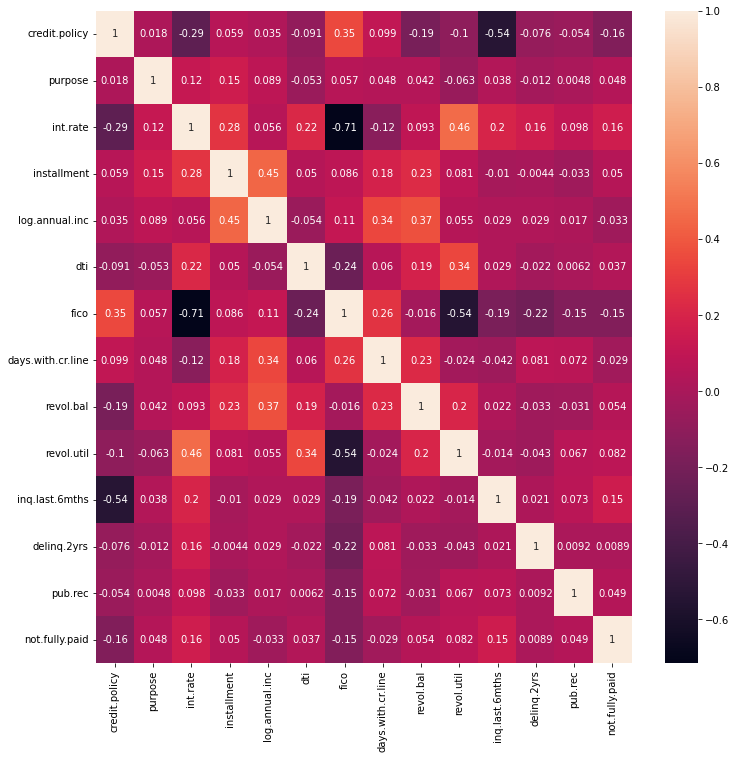

In [11]:
# Visualize it with a contour plot

f,axes = plt.subplots(1,1,figsize = (12,12))
sns.heatmap(loan_data.corr(), annot = True, ax = axes)

#### From above, the correlations are pretty okay. No strong correlations between the target and any of the features. Let's build the model with all the features and decide.

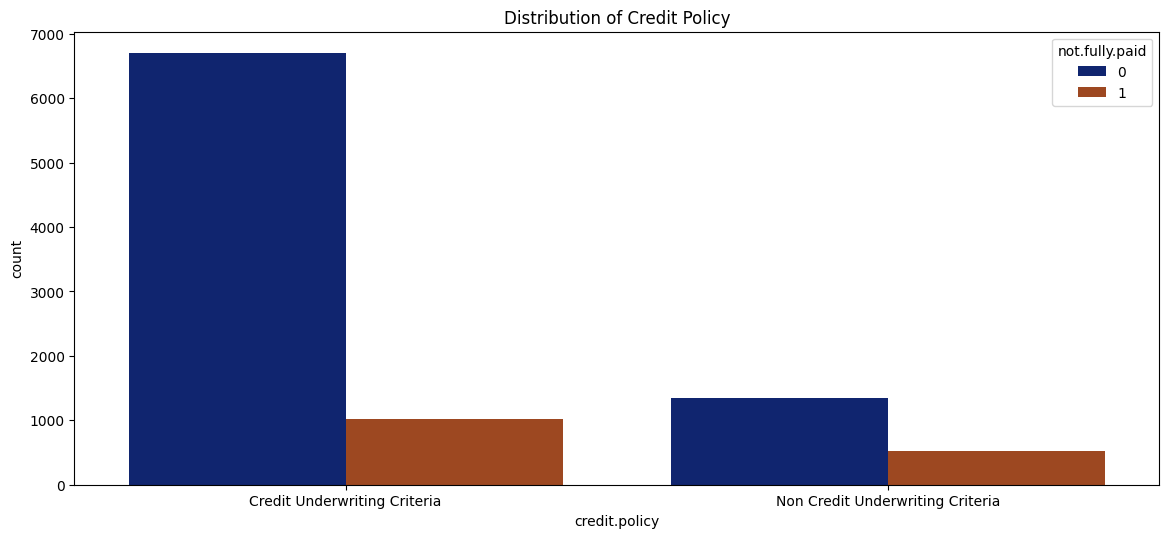

In [12]:
# Some EDA
data_policy = loan_data.copy()
data_policy['credit.policy'] = data_policy['credit.policy'].map({0: 'Non Credit Underwriting Criteria',
                                                                  1: 'Credit Underwriting Criteria'})
data_policy['Will Default'] = data_policy['not.fully.paid'].map({0: 'No', 1: 'Yes'})
plt.figure(figsize=(14,6), dpi = 100)
sns.countplot(data = data_policy, x = 'credit.policy', hue= 'not.fully.paid', palette = 'dark')
plt.title('Distribution of Credit Policy')
plt.show()

In [13]:
# Lets define X and y. None of the features strongly correlates with the target. So, none will be dropped.
X = loan_data.drop(['not.fully.paid'],axis=1)
y = loan_data['not.fully.paid']

In [14]:
# The target is imbalance data
y.value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

In [15]:
# Now we routinely handle the imbalance
X, y = SMOTE().fit_resample(X,y)

In [16]:
# Check to make sure the resampling was done correctly
y.value_counts()

0    8045
1    8045
Name: not.fully.paid, dtype: int64

In [17]:
# Large variations, necessitating the need for scaling
sc = StandardScaler()
df_names = X.columns
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=df_names)

In [18]:
#SPLITTING X and y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 110)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12872, 13)
(3218, 13)
(12872,)
(3218,)


In [20]:
# Build the model architecture 
input_shape = [X.shape[1]]
model = keras.Sequential(
    [
        keras.layers.Dense(
            200, activation="relu", input_shape=input_shape
        ), # Input + hidden layer
        keras.layers.Dense(150, activation="relu"), # hidden layer
        keras.layers.Dropout(0.3), #Aviod or at least reduce overfitting
        keras.layers.Dense(150, activation="relu"),
        keras.layers.Dropout(0.3), #Aviod or at least reduce overfitting
        keras.layers.Dense(1, activation="sigmoid"), #output layer
    ]
)

In [21]:
# Compile the model
model.compile(optimizer='Adam',
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               2800      
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               22650     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 55,751
Trainable params: 55,751
Non-traina

In [22]:
# Fit the model
early_stopping = keras.callbacks.EarlyStopping(patience = 25, min_delta = 0.001, 
                                               restore_best_weights =True,monitor='val_loss' )
mdl_history = model.fit(X_train,y_train,
                        epochs=1000,
                        validation_data=(X_test,y_test),
                        shuffle = True,
                        batch_size = 50,
                        callbacks=[early_stopping],
                        verbose = 1,)

Epoch 1/1000
258/258 [==============================] - 6s 8ms/step - loss: 0.5997 - binary_accuracy: 0.6659 - val_loss: 0.5796 - val_binary_accuracy: 0.6821
Epoch 2/1000
258/258 [==============================] - 2s 7ms/step - loss: 0.5729 - binary_accuracy: 0.6942 - val_loss: 0.5664 - val_binary_accuracy: 0.6955
Epoch 3/1000
258/258 [==============================] - 2s 7ms/step - loss: 0.5610 - binary_accuracy: 0.7021 - val_loss: 0.5596 - val_binary_accuracy: 0.7029
Epoch 4/1000
258/258 [==============================] - 2s 7ms/step - loss: 0.5517 - binary_accuracy: 0.7063 - val_loss: 0.5589 - val_binary_accuracy: 0.7001
Epoch 5/1000
258/258 [==============================] - 1s 4ms/step - loss: 0.5437 - binary_accuracy: 0.7132 - val_loss: 0.5525 - val_binary_accuracy: 0.7057
Epoch 6/1000
258/258 [==============================] - 1s 3ms/step - loss: 0.5370 - binary_accuracy: 0.7227 - val_loss: 0.5461 - val_binary_accuracy: 0.7116
Epoch 7/1000
258/258 [==============================

In [23]:
mdl_history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [24]:
hist = pd.DataFrame(mdl_history.history)
hist['epoch'] = mdl_history.epoch
hist.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
40,0.292595,0.870183,0.538894,0.774705,40
41,0.288693,0.869173,0.543065,0.776569,41
42,0.285993,0.871892,0.544926,0.778434,42
43,0.279366,0.872902,0.526185,0.784338,43
44,0.279770,0.873757,0.537972,0.774705,44


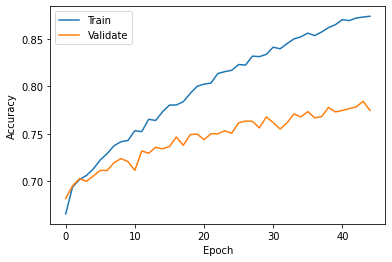

In [25]:
plt.plot(mdl_history.history['binary_accuracy'])
plt.plot(mdl_history.history['val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validate'])

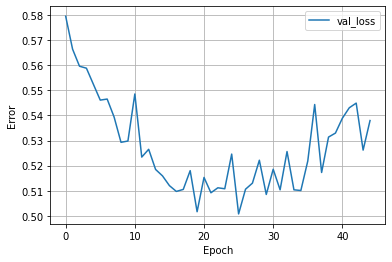

In [26]:
plt.plot(mdl_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

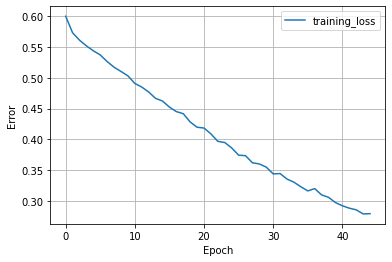

In [27]:
plt.plot(mdl_history.history['loss'], label='training_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [28]:
predictions =model.predict(X_test).astype("int32")             

In [29]:
# Show the confusion matrix
y_pred = []
for val in predictions:
    y_pred.append(np.argmax(val))   
#convert 0 1 to 1 and 1 0 as 0
cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)

[[1589    0]
 [1629    0]]


In [30]:
# Plot the classification
creport=metrics.classification_report(y_test,predictions)
print(creport)

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1589
           1       1.00      0.00      0.00      1629

    accuracy                           0.49      3218
   macro avg       0.75      0.50      0.33      3218
weighted avg       0.75      0.49      0.33      3218



In [31]:
# Further check the accuracy score
#metrics.accuracy_score(y_test, predictions)

In [32]:
# Print the training accuracy one more time
loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %.5f'  % acc)
print('Loss: %.5f' % loss)

Training accuracy: 0.83662
Loss: 0.37424


In [33]:
# Print the training accuracy one more time
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: %.5f'  % acc)
print('Loss: %.5f' % loss)

Test accuracy: 0.74984
Loss: 0.50161


In [34]:
# Use pip to visualize the feature importance. This is very expensive. Only use with enough GPU resources.
#!pip install shap

In [35]:
#import shap
# Look at feature importance with shap. This is very expensive!
#explainer = shap.KernelExplainer(model = model, data = X_train,link = 'identity' )
#shap_values = explainer.shap_values(X_train)
#display(shap_values)

In [36]:
## Check on test data - Expensive for my system
#shap_values_test = explainer.shap_values(X_test)
#shap.summary_plot(shap_values_test, class_names = class_names, feature_names = X_test.columns)
#shap.summary_plot(shap_values_test[0], X_test)

In [37]:
# Plot the original data and predictions side-by-side
compare_data = pd.DataFrame({'Original_Data':y_test, 'Predicted_data':y_pred } )
compare_data

,Original_Data,Predicted_data
14183,1,0
22,0,0
10757,1,0
11500,1,0
7976,0,0
...,...,...
9367,0,0
10804,1,0
14747,1,0
7969,0,0


## End of Case Study